In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('/content/traffic_tweets_2922_anon.csv')
df.head()

,Unnamed: 0,Date,Tweet,likeCount
0,0,2022-12-22 23:30:00+00:00,The Metropolitan Manila Development Authority ...,1
1,1,2022-12-22 23:23:42+00:00,This woman prevented prrd from having emergenc...,5
2,2,2022-12-22 23:13:38+00:00,Traffic Update as of 07:12 am\nSouth Metro Man...,1
3,3,2022-12-22 23:03:08+00:00,Traffic Update as of 07:02 am\nManila-Cavite T...,1
4,4,2022-12-22 22:03:00+00:00,the only one place you can possibly find traff...,4


In [ ]:
df['Tweet'][0]

'The Metropolitan Manila Development Authority (MMDA) is now allowing shopping malls in Metro Manila to resume their normal operating hours after the expected holiday traffic volume did not occur.\n\nhttps://t.co/JVmSedLz1N'

**Preprocessing the Data**

In [ ]:
!pip install langdetect


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993221 sha256=e99e7bb878e97f8f7f6e12ea5557603f534e55412a62fd9f727854452defac00
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [ ]:
from langdetect import detect, DetectorFactory

DetectorFactory.seed = 0

# Function to detect if the tweet is in English
def is_english(tweet):
    try:
        return detect(tweet) == 'en'
    except:
        return False

# Step 2: Remove non-English tweets, keeping the original DataFrame name
df = df[df['Tweet'].apply(is_english)].copy()
df.reset_index(drop=True, inplace=True)

In [ ]:
import re

# Function to clean tweet text
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters and numbers
    text = text.lower().strip()  # Convert to lowercase and remove extra spaces
    return text

df['cleaned_tweet'] = df['Tweet'].apply(clean_text)
df['cleaned_tweet'][0]

'the metropolitan manila development authority mmda is now allowing shopping malls in metro manila to resume their normal operating hours after the expected holiday traffic volume did not occur'

**Tokenization**

In [ ]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Tokenize the cleaned tweets
df['tokenized_tweet'] = df['cleaned_tweet'].apply(word_tokenize)
df['tokenized_tweet'][0]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['the',
 'metropolitan',
 'manila',
 'development',
 'authority',
 'mmda',
 'is',
 'now',
 'allowing',
 'shopping',
 'malls',
 'in',
 'metro',
 'manila',
 'to',
 'resume',
 'their',
 'normal',
 'operating',
 'hours',
 'after',
 'the',
 'expected',
 'holiday',
 'traffic',
 'volume',
 'did',
 'not',
 'occur']

**Removing Stop Words**

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')

# Load the default English stopwords list
stop_words = set(stopwords.words('english'))

# Remove 'not' from the stopwords list
stop_words.discard('not')

# Remove stopwords (excluding 'not') from tokenized tweets
df['filtered_tweet'] = df['tokenized_tweet'].apply(lambda x: [word for word in x if word not in stop_words])

df['filtered_tweet'][0]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['metropolitan',
 'manila',
 'development',
 'authority',
 'mmda',
 'allowing',
 'shopping',
 'malls',
 'metro',
 'manila',
 'resume',
 'normal',
 'operating',
 'hours',
 'expected',
 'holiday',
 'traffic',
 'volume',
 'not',
 'occur']

**Lemmatization**

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Lemmatize the filtered tweets
df['lemmatized_tweet'] = df['filtered_tweet'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
# Join lemmatized words back into strings for vectorization
df['final_tweet'] = df['lemmatized_tweet'].apply(lambda x: ' '.join(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df['final_tweet']

,final_tweet
0,metropolitan manila development authority mmda...
1,woman prevented prrd emergency power address t...
2,traffic update south metro manila skyway atgra...
3,traffic update manilacavite toll expressway op...
4,one place possibly find traffic manila airport...
...,...
5530,hello manila im released quarantine free exper...
5531,youre north planning go manila today via nlex ...
5532,today manila postcard sunset old doubt asked s...
5533,literally nagroadtrip lang around city entire ...


**MODEL TRAINING**

In [ ]:
pip install vaderSentiment pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.0 MB/s eta 0:00:00


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_label(text):
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return 1  # Positive
    elif score <= -0.05:
        return 0  # Negative
    else:
        return 2  # Neutral

# Apply the function to the tweet column
df['sentiment'] = df['final_tweet'].apply(get_sentiment_label)

In [ ]:
df['sentiment']

,sentiment
0,1
1,0
2,2
3,2
4,2
...,...
5530,1
5531,0
5532,1
5533,1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import joblib

# Step 1: Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['final_tweet'])  # Features (tweets vectorized)
y = df['sentiment']                        # Labels (sentiment)

# Step 2: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train a Logistic Regression model (you can choose other models too)
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

**Model Testing and Results**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict the sentiments on the test set
y_pred = model.predict(X_test)

# Display the classification report
report = classification_report(y_test, y_pred, target_names=["Negative", "Positive", "Neutral"])
print(report)


              precision    recall  f1-score   support

    Negative       0.72      0.69      0.71       352
    Positive       0.72      0.83      0.77       422
     Neutral       0.86      0.73      0.79       333

    accuracy                           0.75      1107
   macro avg       0.76      0.75      0.75      1107
weighted avg       0.76      0.75      0.75      1107



In [ ]:
# Evaluate the model on test data (optional)
accuracy = model.score(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.7533875338753387


In [ ]:
# Create a DataFrame to compare actual and predicted labels
results_df = pd.DataFrame({
    'Tweet': df.loc[y_test.index, 'final_tweet'],  # Get original tweets based on test set indices
    'Actual Sentiment': y_test,
    'Predicted Sentiment': y_pred
})

# Map numeric sentiments to their string representations
sentiment_map = {0: "Negative", 1: "Positive", 2: "Neutral"}
results_df['Actual Sentiment'] = results_df['Actual Sentiment'].map(sentiment_map)
results_df['Predicted Sentiment'] = results_df['Predicted Sentiment'].map(sentiment_map)

# Display the results
print(results_df.head(10))  # Display the first 10 results


                                                  Tweet Actual Sentiment  \
2629  running errand hour tapos ang traffic pa sa ma...          Neutral   
1235  anong meron kahapon traffic jam around metro m...         Negative   
2181  henrkfisjsjs puta ng traffic sb wyat manila sb...          Neutral   
230   driving around metro manila today car pero kai...          Neutral   
4829  parex not never solution metro manila traffic ...         Negative   
3539  metropolitan manila development authority send...         Negative   
5119  ill take davao highly polluted longer traffic ...         Negative   
3904  moved manila year ago im glad hahahahaha lived...         Positive   
810   thanking god ive blessed enough walk wherever ...         Positive   
1297  shopping mall metro manila open pm starting no...         Positive   

     Predicted Sentiment  
2629             Neutral  
1235            Negative  
2181             Neutral  
230             Negative  
4829            Negative  
3

In [ ]:
# Optionally, you can visualize the confusion matrix using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[243  88  21]
 [ 53 349  20]
 [ 41  50 242]]


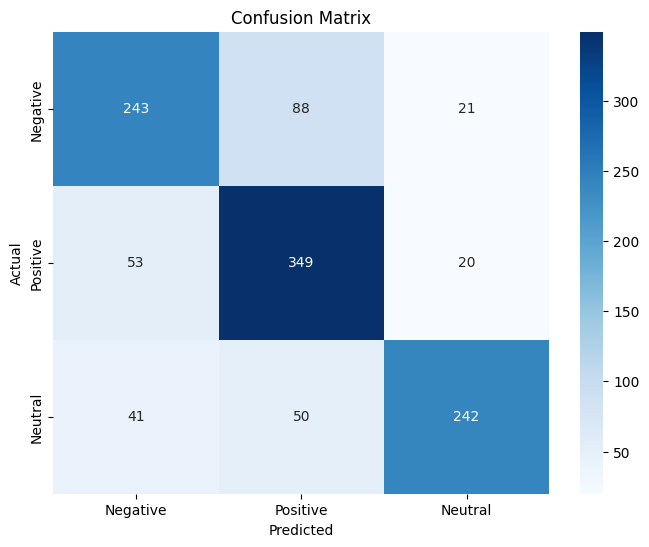

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Positive", "Neutral"],
            yticklabels=["Negative", "Positive", "Neutral"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Save the vectorizer and the model for later use in Streamlit
joblib.dump(vectorizer, 'vectorizer.joblib')
joblib.dump(model, 'sentiment_model.joblib')

['sentiment_model.joblib']

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.9 MB/s eta 0:00:00


In [ ]:
%%writefile app.py

Writing app.py


In [ ]:
!wget -q -O - ipv4.icanhazip.com

35.199.181.115


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.199.181.115:8501

your url is: https://tired-ways-wave.loca.lt
